#### This notebook presents how to perform maximum-likelihood parameter estimation for multiple neurons.  The neurons depend on each other through a set of weights.

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import csv
%matplotlib inline

In [166]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),'..'))
sys.path.append(os.path.join(os.getcwd(),'..','code'))
sys.path.append(os.path.join(os.getcwd(),'..','data'))

In [167]:
import filters
import likelihood_functions as lk
import PoissonProcessClasses as PP
import auxiliary_functions as auxfun

In [168]:
import imp
imp.reload(filters)
imp.reload(lk)
imp.reload(auxfun)
imp.reload(PP)


<module 'PoissonProcessClasses' from '../code/PoissonProcessClasses.py'>

In [169]:
# Number of neurons
nofCells = 2

Reading input-output data:

In [170]:
# creating the path to the data
data_path = os.path.join(os.getcwd(),'..','data')

# reading stimulus
Stim = np.array(pd.read_csv(os.path.join(data_path,'Stim.csv'),header = None))

# reading location of spikes
# (lengths of tsp sequences are not equal so reading them line by line)
tsp_list = []
with open(os.path.join(data_path,'tsp2.csv')) as csvfile:
    tspreader = csv.reader(csvfile)
    for row in tspreader:
        tsp_list.append(row)

Extracting a spike train from spike positions:

In [171]:
dt = 0.01
y_list = []
for tsp in tsp_list:
    tsp = np.array(tsp).astype(np.float)
    tsp_int = np.ceil((tsp - dt*0.001)/dt)
    tsp_int = np.reshape(tsp_int,(tsp_int.shape[0],1))
    tsp_int = tsp_int.astype(int)
    y_list.append(np.array([item in tsp_int for item in np.arange(Stim.shape[0]/dt)]).astype(int))

Creating filters:

In [172]:
# create a stimulus filter
kpeaks = np.array([0,round(20/3)])
pars_k = {'neye':5,'n':5,'kpeaks':kpeaks,'b':3}
K,K_orth,kt_domain = filters.createStimulusBasis(pars_k, nkt = 20) 

In [173]:
# create a post-spike filter
hpeaks = np.array([0.1,2])
pars_h = {'n':5,'hpeaks':hpeaks,'b':.4}
H,H_orth,ht_domain = filters.createPostSpikeBasis(pars_h,dt)

Conditional Intensity (spike rate):
$$\lambda_{\beta}(i) = \exp(K(\beta_k)*Stim + H(\beta_h)*y + \sum_{j\ne i}w_j I(\beta_{I})*y_j)$$

$$\lambda_{\beta}(i) = \exp(M_k\beta_k + M_h \beta_h + Y w)$$

Creating a matrix of covariates:

In [174]:
M_k = lk.construct_M_k(Stim,K,dt)

In [175]:
M_h_list = []
for tsp in tsp_list:
    tsp = np.array(tsp).astype(np.float)
    M_h_list.append(lk.construct_M_h(tsp,H_orth,dt,Stim))



In [176]:
# creating a matrix of output covariates
Y = np.array(y_list).T

<!---Simulating a neuron spike trains:-->

In [178]:
M_list = []
for M_h in M_h_list:
    M_list.append(np.hstack((M_k,M_h,Y)))

Conditional intensity as a function of the covariates:
$$ \lambda_{\beta} = \exp(M\beta) $$

Create a Poisson process model with this intensity:

Setting initial parameters:

In [180]:
coeff_k0 = np.array([ 0.061453,0.284916,0.860335,1.256983,0.910615,0.488660,-0.887091,0.097441,0.026607,-0.090147])
coeff_h0 = np.zeros((5,))
coeff_w0 = np.zeros((nofCells,))

pars0 = np.hstack((coeff_k0,coeff_h0,coeff_w0))

Fitting the likelihood:

In [181]:
res_list = []
for i in range(len(y_list)):
    model = PP.PPModel(M_list[i].T,dt = dt)
    res_list.append(model.fit(y_list[i],start_coef = pars0,method = 'Nelder-Mead'))

Optimization terminated successfully.
         Current function value: -461.491325
         Iterations: 5815
         Function evaluations: 7550
Optimization terminated successfully.
         Current function value: -670.786868
         Iterations: 5134
         Function evaluations: 6679


../code/PoissonProcessClasses.py:176: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if start_coef==None:
/Users/val/anaconda/lib/python3.4/site-packages/scipy/optimize/_minimize.py:358: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
/Users/val/anaconda/lib/python3.4/site-packages/scipy/optimize/_minimize.py:362: RuntimeWarning: Method Nelder-Mead does not use Hessian information (hess).
  RuntimeWarning)


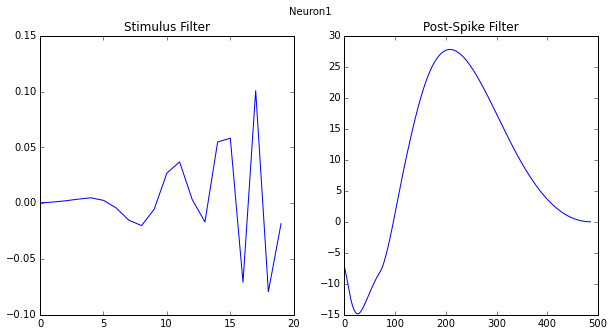

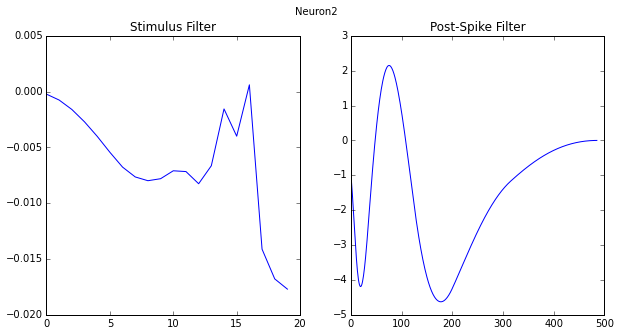

In [182]:
for i in range(len(res_list)):
    k_coeff_predicted = res_list[i].x[:10]
    h_coeff_predicted = res_list[i].x[10:15]
    
    fig,axs = plt.subplots(1,2,figsize = (10,5))
    fig.suptitle('Neuron%d'%(i+1))
    axs[0].plot(-kt_domain[::-1],np.dot(K,k_coeff_predicted))
    axs[0].set_title('Stimulus Filter')
    axs[1].plot(ht_domain,np.dot(H,h_coeff_predicted))
    axs[1].set_title('Post-Spike Filter')

Extracting the weight matrix:

In [183]:
W = np.array([res.x[-2:] for res in res_list])
print(W)

[[ 2.29988124  3.67983112]
 [-1.74801261  9.05287126]]


Note: the stimulus and the post-spike estimates can be different for different neurons.